## Data Source
### [NYC Taxi Trips](https://github.com/uber-web/kepler.gl-data/blob/master/nyctrips/data.csv)
This data set, downloaded from [NYC Taxi and Limousine Commission (TLC) website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), includes yellow and green taxi trip records capturing pick-up and drop-off dates/times, pick-up and drop-off locations (latitude, longitude), trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

### [NYC restaurant locations](https://drive.google.com/file/d/11oMqNz_0aksP_vFXMQhA6a5rrWPshrew/view?usp=share_link)
- The New York City Department of Health and Mental Hygiene (DOHMH) conducts unannounced restaurant inspections on an annual basis in order to check for compliance with policies on food handling. Data on these restaurant inspection results are publicly available at [NYC Open Data](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j) and are updated daily. The specific data set for download above was accessed on 8/28/17 and contains records from 2014 - 2017. This older data was chosen in order to be more aligned with the taxi data, collected in 2015. This is important, since there is high turnover in restaurants over time (i.e., many go out of business).  
- The data set contains information on restaurant name and location, type of food (CUISINE DESCRIPTION), inspection date, and details on violation codes, total scores, and associated grades. The data is longitudinal in nature, with multiple rows per restaurant representing inspections over time. A full data dictionary is available [here](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j).
- For the following questions, **we will focus on analyzing the locations of restaurants** (specified by the combination of their building, street, and zipcode features) **and not their inspection results**.



## My Workflow
- Install all the required packages
- First I downloaded both the datasets
- Read the description and metadata of the datasets
- Understand the problem statement and find the intuition with the given data
- Data Preparation
    - NYC Taxi Data: Get the data between lunchtime (11:30am - 2pm) and dinnertime (5pm - 9pm)
    - NYC Restaurant Data: Remove the duplicate data
- Learn how to link the data spatially
- Add the restaurant closest to the trip destination as expected restaurant visited by the passengers
- Fix issue displaying kepler.gl on the notebook
- Learn basic concepts of spatial data science
- Find how to convert physical location into geographic location (found GeoPandas)
- Read the documentation og GeoPandas and convert the physical location into geographic location
- Plot the restaurant locations in the map
- Create a function to calculate the distance between 2 geographic locations
- Plot both restaurant locations and taxi drop location using Folium
- Fetch the data from the linked dataset and plot the graphs for required questions


### Reference Notebooks and Links
- [Learn How to Visualize Geospatial Data in Jupyter using kepler.gl](https://www.analyticsvidhya.com/blog/2020/06/learn-visualize-geospatial-data-jupyter-kepler/)
- [NYC Taxis: EDA and Mapping Position to Borough](https://www.kaggle.com/code/muonneutrino/nyc-taxis-eda-and-mapping-position-to-borough)
- [GeoCoding](https://towardsdatascience.com/geocode-with-python-161ec1e62b89)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import math

# Visualization
from keplergl import KeplerGl
import matplotlib
import matplotlib.pyplot as plt

# Map
import folium
from branca.element import Figure

# GeoCoding
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Photon

# Find Distance between two points
import geopy.distance

# Calcuate distance between two geolocations
from scipy.spatial import KDTree

pd.options.mode.chained_assignment = None  # default='warn'

## NYC Taxi Trips

In [2]:
taxi_df = pd.read_csv("input/data.csv")
print(taxi_df.shape)
taxi_df.head()

(97986, 12)


VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
0         2  2015-01-15 19:05:39 +00:00  2015-01-15 19:23:42 +00:00   
1         2  2015-01-15 19:05:39 +00:00  2015-01-15 19:32:00 +00:00   
2         2  2015-01-15 19:05:40 +00:00  2015-01-15 19:21:00 +00:00   
3         2  2015-01-15 19:05:40 +00:00  2015-01-15 19:28:18 +00:00   
4         2  2015-01-15 19:05:41 +00:00  2015-01-15 19:20:36 +00:00   

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           2.38        -73.976425        40.739811   
2                5           2.83        -73.968704        40.754246   
3                5           8.33        -73.863060        40.769581   
4                1           2.37        -73.945541        40.779423   

   dropoff_longitude  dropoff_latitude  fare_amount  tip_amount  total_amount  
0         -73.974785         40.750618         12.0        3.25         17.05  
1         -73.983978         40.757889         16.5        4.38         22.68  
2         -73.955124         40.786858         12.5        0.00         14.30  
3         -73.952713         40.785782         26.0        8.08         41.21  
4         -73.980850         40.786083         11.5        0.00         13.30

In [3]:
# Remove the features that are not required for this task
taxi_df = taxi_df.drop(['VendorID', 'tpep_pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'fare_amount', 'total_amount'],axis=1)  
# Filter out the data for which there are no passengers
taxi_df = taxi_df.loc[taxi_df["passenger_count"]>0]
print(taxi_df.shape)
taxi_df.head()

(97941, 6)


tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:23:42 +00:00                1           1.59   
1  2015-01-15 19:32:00 +00:00                1           2.38   
2  2015-01-15 19:21:00 +00:00                5           2.83   
3  2015-01-15 19:28:18 +00:00                5           8.33   
4  2015-01-15 19:20:36 +00:00                1           2.37   

   dropoff_longitude  dropoff_latitude  tip_amount  
0         -73.974785         40.750618        3.25  
1         -73.983978         40.757889        4.38  
2         -73.955124         40.786858        0.00  
3         -73.952713         40.785782        8.08  
4         -73.980850         40.786083        0.00

In [4]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97941 entries, 0 to 97985
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tpep_dropoff_datetime  97941 non-null  object 
 1   passenger_count        97941 non-null  int64  
 2   trip_distance          97941 non-null  float64
 3   dropoff_longitude      97941 non-null  float64
 4   dropoff_latitude       97941 non-null  float64
 5   tip_amount             97941 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 5.2+ MB


### Get the data within lunchtime or dinnertime

In [5]:
index = pd.DatetimeIndex(taxi_df['tpep_dropoff_datetime'])

# Get lunch data
taxi_lunch = taxi_df.iloc[index.indexer_between_time('11:30','14:00')]
taxi_lunch["mealtime"] = ['Lunch']*taxi_lunch.shape[0]

# Get dinner data
taxi_dinner = taxi_df.iloc[index.indexer_between_time('17:00','21:00')]
taxi_dinner["mealtime"] = ['Dinner'] * taxi_dinner.shape[0]


frames = [taxi_lunch, taxi_dinner]
taxi_data = pd.concat(frames)
taxi_data

tpep_dropoff_datetime  passenger_count  trip_distance  \
96     2015-01-15 11:31:54 +00:00                1           12.5   
105    2015-01-15 11:53:23 +00:00                1            2.2   
106    2015-01-15 11:43:13 +00:00                1            1.2   
107    2015-01-15 12:01:53 +00:00                1            6.8   
108    2015-01-15 11:49:54 +00:00                1            1.9   
...                           ...              ...            ...   
97811  2015-01-15 20:24:23 +00:00                1            2.7   
97812  2015-01-15 20:32:32 +00:00                1            6.2   
97813  2015-01-15 20:29:18 +00:00                3            1.7   
97814  2015-01-15 20:23:13 +00:00                1            1.3   
97815  2015-01-15 20:30:35 +00:00                2            1.9   

       dropoff_longitude  dropoff_latitude  tip_amount mealtime  
96            -73.946861         40.616211        0.00    Lunch  
105           -74.004623         40.742065        3.32    Lunch  
106           -73.952957         40.786644        1.60    Lunch  
107           -74.007690         40.717655        5.06    Lunch  
108           -73.981400         40.757473        2.25    Lunch  
...                  ...               ...         ...      ...  
97811         -74.007416         40.741055        1.00   Dinner  
97812         -73.953674         40.779285        5.00   Dinner  
97813         -73.972626         40.759567        0.00   Dinner  
97814         -73.964134         40.759216        1.65   Dinner  
97815         -73.997246         40.714252        2.25   Dinner  

[33467 rows x 7 columns]

### Taxi Drop Location Plot

In [6]:
map1=KeplerGl(height=500)
map1.add_data(data=taxi_data,name='New York City Taxi Trips')
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York City Taxi Trips': {'index': [96, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 11…

## Restaurant Data


In [7]:
# restaurant_data = pd.read_csv("input/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
# restaurant_data = restaurant_data.iloc[:50, :]
# print(restaurant_data.shape)
# restaurant_data.head()

In [8]:
# restaurant_data.columns

As we can see this dataset contains only the **physical address** of the restaurants, we can get the **geographic location** using geopanda.

### Geocoding

1. Drop the columns that are not required 
2. Remove the restaurant that are repeated
3. From the 'BUILDING', 'STREET' and 'BORO' details we could find the Latitude and Longitude details.

NOTE: Geocoding takes a lot of time to fetch the locations from API. (We can use a separate dataset from the same website The New York City Department of Health and Mental Hygiene (DOHMH). This data already contains latitude and longitude, however the number of datapoints are less than the given dataset.)

TODO:
- Run the geocolocator once and store the locations in a file. 
- Append the stored locations as geographic loction and use it for plotting and EDA

Drop the columns that are not required

In [9]:
# restaurant_sub_data = restaurant_data.drop(['PHONE', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
#        'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
#        'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],axis=1)  
# print(restaurant_sub_data.shape)
# restaurant_sub_data.head()

In [10]:
# # Remove the columns that are repeated
# restaurant_sub_data = restaurant_sub_data.drop_duplicates(subset='CAMIS', keep="first")
# print(restaurant_sub_data.shape)


In [11]:
# restaurant_sub_data["ADDRESS"] = restaurant_sub_data["BUILDING"] + ',' + restaurant_sub_data["STREET"] + ','+ restaurant_sub_data["BORO"]
# restaurant_sub_data.head()

In [12]:
# st = time.time()
# geolocator = Photon(user_agent="nyc_restaurant_locations")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)
# restaurant_sub_data['location'] = restaurant_sub_data.loc[:,'ADDRESS'].apply(geocode).copy()
# print("Time Taken: ", time.time() - st)

In [13]:
# #3 - create longitude, laatitude and altitude from location column (returns tuple)
# restaurant_sub_data['point'] = restaurant_sub_data['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [14]:
# restaurant_sub_data[['Latitude', 'Longitude', 'altitude']] = pd.DataFrame(restaurant_sub_data['point'].tolist(), index=restaurant_sub_data.index)


In [15]:
# restaurant_sub_data.head()

In [16]:
# duplicateRows = restaurant_sub_data[restaurant_sub_data.duplicated(subset=['ADDRESS'])]
# duplicateRows

In [17]:
# map2 = KeplerGl(height=500)
# map2.add_data(data=restaurant_sub_data,name='New York City Restaurants')
# map2

## Restaurant Data - With Latitude and Logitude

In [18]:
restaurant_data = pd.read_csv("input/DOHMH_New_York_City_Restaurant_Inspection_Results_full.csv")
# restaurant_data = restaurant_data.iloc[:10000, :]
print(restaurant_data.shape)
restaurant_data.head()

(209163, 27)


CAMIS                       DBA       BORO BUILDING              STREET  \
0  50120622           TRINITY COMMONS  Manhattan       76       TRINITY PLACE   
1  50122164                       NaN     Queens     1524  COLLEGE POINT BLVD   
2  50118627  HOSTOS COMMUNITY COLLEGE      Bronx      500     GRAND CONCOURSE   
3  50128814                       NaN          0      NaN                 NaN   
4  50010000         BLOOMBERG 731 LEX  Manhattan      731    LEXINGTON AVENUE   

   ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0  10006.0  2123376092                 NaN      01/01/1900   
1  11356.0  9178642912                 NaN      01/01/1900   
2  10451.0  9174188577                 NaN      01/01/1900   
3      NaN  3477630031                 NaN      01/01/1900   
4  10022.0  2126173236            American      06/03/2022   

                                              ACTION  ...  \
0                                                NaN  ...   
1                                                NaN  ...   
2                                                NaN  ...   
3                                                NaN  ...   
4  No violations were recorded at the time of thi...  ...   

                         INSPECTION TYPE   Latitude  Longitude  \
0                                    NaN  40.708423 -74.012534   
1                                    NaN  40.784029 -73.845827   
2                                    NaN  40.818079 -73.927515   
3                                    NaN        NaN        NaN   
4  Cycle Inspection / Initial Inspection  40.761880 -73.968421   

   Community Board Council District Census Tract        BIN           BBL  \
0            101.0              1.0       1300.0  1090830.0  1.000510e+09   
1            407.0             19.0      92500.0  4098210.0  4.040760e+09   
2            201.0             17.0       5100.0  2001019.0  2.023430e+09   
3              NaN              NaN          NaN        NaN           NaN   
4            106.0              4.0      11203.0  1086160.0  1.013138e+09   

    NTA  Location Point  
0  MN25             NaN  
1  QN23             NaN  
2  BX39             NaN  
3   NaN             NaN  
4  MN19             NaN  

[5 rows x 27 columns]

In [19]:
# Get the number of unique Boroughs
unique, counts = np.unique(restaurant_data['BORO'], return_counts=True)
print(np.asarray((unique, counts)).T)
print(len(unique))

[['0' 79]
 ['Bronx' 19792]
 ['Brooklyn' 55356]
 ['Manhattan' 78199]
 ['Queens' 49103]
 ['Staten Island' 6634]]
6


In [20]:
restaurant_data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point'],
      dtype='object')

In [21]:
restaurant_sub_data = restaurant_data.drop(['BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point'],axis=1)  
print(restaurant_sub_data.shape)
restaurant_sub_data.head()

(209163, 6)


CAMIS                       DBA       BORO CUISINE DESCRIPTION  \
0  50120622           TRINITY COMMONS  Manhattan                 NaN   
1  50122164                       NaN     Queens                 NaN   
2  50118627  HOSTOS COMMUNITY COLLEGE      Bronx                 NaN   
3  50128814                       NaN          0                 NaN   
4  50010000         BLOOMBERG 731 LEX  Manhattan            American   

    Latitude  Longitude  
0  40.708423 -74.012534  
1  40.784029 -73.845827  
2  40.818079 -73.927515  
3        NaN        NaN  
4  40.761880 -73.968421

In [22]:
# Drop the rows with NaN
restaurant_sub_data = restaurant_sub_data.dropna(subset=['Latitude', 'Longitude', 'CUISINE DESCRIPTION', 'BORO'])
restaurant_sub_data.shape

(204552, 6)

In [23]:
# Get the number of unique Boroughs
unique, counts = np.unique(restaurant_data['BORO'], return_counts=True)
print(np.asarray((unique, counts)).T)
print(len(unique))

[['0' 79]
 ['Bronx' 19792]
 ['Brooklyn' 55356]
 ['Manhattan' 78199]
 ['Queens' 49103]
 ['Staten Island' 6634]]
6


### Remove Outlier

In [24]:
# When the data has value of latitude as 0, remove those values
restaurant_sub_data.drop(restaurant_sub_data.loc[restaurant_sub_data['Latitude']==0].index, inplace=True)
restaurant_sub_data.shape

(201728, 6)

In [25]:
unique, counts = np.unique(restaurant_sub_data['BORO'], return_counts=True)
print(np.asarray((unique, counts)).T)
print(len(unique))

[['Bronx' 19079]
 ['Brooklyn' 53957]
 ['Manhattan' 74967]
 ['Queens' 47299]
 ['Staten Island' 6426]]
5


### Restaurants Location Plot

In [26]:
map2 = KeplerGl(height=500)
map2.add_data(data=restaurant_sub_data,name='New York City Restaurants')
map2


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York City Restaurants': {'index': [4, 9, 19, 23, 94, 100, 104, 109, 115, 117, 124, 126, 13…

## Link the datasets based on distance

In [27]:
# Function to get the distance between 2 locations in meters
def get_distance(p1, p2):
    return geopy.distance.geodesic(p1, p2).m


### Method 1: Map all the restaurants location within 50 meters of taxi drop location
NOTE: This method takes a long time to run as it's complexity is O(N^2).

We will be using a different method to map the distances in matrices using KDTree (Method 2)

In [28]:
# distance_threshold = 50  # In Meters

In [29]:

# taxi_lat = taxi_data['dropoff_latitude'].tolist()
# taxi_lon = taxi_data['dropoff_longitude'].tolist()
# res_lat = restaurant_sub_data['Latitude'].tolist()
# res_lon = restaurant_sub_data['Longitude'].tolist()

# all_valid_restaurants = []
# all_cuisine = []
# all_borough = []
# for t in range(0, taxi_data.shape[0]):
#     coords_1 = (taxi_lat[t], taxi_lon[t])
    
#     if t%10 == 0:
#         print(t, "------------------")
    
#     valid_restaurants = []
#     cuisine = []
#     borough = []
#     valid_distances = []
#     for i in range(0, restaurant_sub_data.shape[0]):
#         coords_2 = (res_lat[i], res_lon[i])
#         dist = get_distance(coords_1, coords_2)    
#         if dist < distance_threshold:
# #             print("Found", t, i, dist)
# #             print(coords_1, coords_2)
#             valid_restaurants.append(i)
#             valid_distances.append(dist)
#             cuisine.append(restaurant_sub_data["CUISINE DESCRIPTION"].iloc[i])
#             borough.append(restaurant_sub_data["BORO"].iloc[i])
            
# #     Add the closest restaurant as the drip destination
#     if len(valid_distances):
#         min_idx = np.argmin(valid_distances)
#         all_valid_restaurants.append(valid_restaurants[min_idx])
#         all_cuisine.append(cuisine[min_idx])
#         all_borough.append(borough[min_idx])
#     else:
#         all_valid_restaurants.append(np.nan)
#         all_cuisine.append(np.nan)
#         all_borough.append(np.nan)
    
# print(all_valid_restaurants)
# print(all_cuisine)

### Method 2: Map all the restaurants location within 50 meters of taxi drop location (KDTree)

In [30]:
taxi_latlon = taxi_data[["dropoff_latitude", "dropoff_longitude"]]
A = list(taxi_latlon.itertuples(index=False, name=None))
print("Number of taxi rides during the mealtime: ", len(A))

restaurant_latlon = restaurant_sub_data[["Latitude", "Longitude"]]
B = list(restaurant_latlon.itertuples(index=False, name=None))
print("Number of restaurants: ", len(B))

Number of taxi rides during the mealtime:  33467
Number of restaurants:  201728


#### Calculate distance between dropoff location and all the nearby restaurants

In [31]:
# Using all the dataset at once creates a very large matrix. 
# We can handle this by calculating the restaurant locations within the threshold distance of drop location in batches
# Create batch of the list
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [32]:
distance_threshold = 0.0005
# distance_threshold = 0.001

def get_valid_restaurants(list_a, list_b):
    # Build a k-d tree for list B
    tree = KDTree(list_b)

    # Find the indices of all the values in B for each value of A that are less than 50 meters
    result = []

    # Run this batches with a size of 1000 because it creates a really big tree when we have a lot of data
    for coord_a in list_a:
        indices = tree.query_ball_point(coord_a, r=distance_threshold, p=2)
        result.append(indices)
    return result


In [33]:
# Using all the dataset at once creates a very large matrix. 
# We can handle this by calculating the restaurant locations within the threshold distance of drop location in batches

# Get the valid restaurants in batches
batch_size = 1000
valid_restaurants = []
for batch_a in batch(A, batch_size):
    batch_res = get_valid_restaurants(batch_a, B)
    valid_restaurants+= batch_res

### LINK DATA: Add the closest restaurant within 50 meters of drop location to the Taxi Dataset

In [34]:
# Get the indices of closest restaurants
closest_restaurants = []
for i, res in enumerate(valid_restaurants):
    a = taxi_latlon.iloc[i]
    v_dist = []
    for j in res:
        b = restaurant_latlon.iloc[j]
        v_dist.append(get_distance(a, b))
    if len(v_dist):
        index_min = np.argmin(v_dist)
        closest_restaurants.append(res[index_min])
    else:
        closest_restaurants.append(np.nan)    

In [35]:
# Add the valid restaurant corresponding to each trip
all_valid_restaurants = []
all_cuisine = []
all_borough = []
res_lat = []
res_lon = []
for dis in closest_restaurants:
    if not math.isnan(dis):
        res_idx = dis
        all_valid_restaurants.append(res_idx)
        all_cuisine.append(restaurant_sub_data["CUISINE DESCRIPTION"].iloc[res_idx])
        all_borough.append(restaurant_sub_data["BORO"].iloc[res_idx])
        res_lat.append(restaurant_sub_data["Latitude"].iloc[res_idx])
        res_lon.append(restaurant_sub_data["Longitude"].iloc[res_idx])
    else:
        all_valid_restaurants.append(np.nan)
        all_cuisine.append(np.nan)
        all_borough.append(np.nan)
        res_lat.append(np.nan)
        res_lon.append(np.nan)

In [36]:
# Link the columns in the dataset
taxi_data['possible_restaurant'] = all_valid_restaurants
taxi_data['cuisine'] = all_cuisine
taxi_data['borough'] = all_borough
taxi_data['res_latitude'] = res_lat
taxi_data['res_longitude'] = res_lon

In [37]:
print(taxi_data.shape)
taxi_data.head()

(33467, 12)


tpep_dropoff_datetime  passenger_count  trip_distance  \
96   2015-01-15 11:31:54 +00:00                1           12.5   
105  2015-01-15 11:53:23 +00:00                1            2.2   
106  2015-01-15 11:43:13 +00:00                1            1.2   
107  2015-01-15 12:01:53 +00:00                1            6.8   
108  2015-01-15 11:49:54 +00:00                1            1.9   

     dropoff_longitude  dropoff_latitude  tip_amount mealtime  \
96          -73.946861         40.616211        0.00    Lunch   
105         -74.004623         40.742065        3.32    Lunch   
106         -73.952957         40.786644        1.60    Lunch   
107         -74.007690         40.717655        5.06    Lunch   
108         -73.981400         40.757473        2.25    Lunch   

     possible_restaurant   cuisine    borough  res_latitude  res_longitude  
96                   NaN       NaN        NaN           NaN            NaN  
105              65663.0  American  Manhattan     40.741907     -74.004659  
106                  NaN       NaN        NaN           NaN            NaN  
107                  NaN       NaN        NaN           NaN            NaN  
108                  NaN       NaN        NaN           NaN            NaN

### Remove all the trips that does not have a restaurant as the destination within the threshold distance

In [38]:
taxi_data = taxi_data[taxi_data['possible_restaurant'].notna()]
print(taxi_data.shape)
taxi_data.head()

(22191, 12)


tpep_dropoff_datetime  passenger_count  trip_distance  \
105  2015-01-15 11:53:23 +00:00                1            2.2   
109  2015-01-15 11:51:31 +00:00                2            0.8   
111  2015-01-15 11:43:38 +00:00                1            1.7   
112  2015-01-15 11:47:17 +00:00                1            1.4   
113  2015-01-15 11:35:28 +00:00                1            0.0   

     dropoff_longitude  dropoff_latitude  tip_amount mealtime  \
105         -74.004623         40.742065        3.32    Lunch   
109         -73.981255         40.763702        2.26    Lunch   
111         -73.981529         40.781258        3.00    Lunch   
112         -73.973595         40.763000        0.00    Lunch   
113         -73.973396         40.763477        4.00    Lunch   

     possible_restaurant     cuisine    borough  res_latitude  res_longitude  
105              65663.0    American  Manhattan     40.741907     -74.004659  
109              92433.0      Donuts  Manhattan     40.763645     -73.981597  
111             168218.0  Coffee/Tea  Manhattan     40.781175     -73.981245  
112             121404.0    American  Manhattan     40.762773     -73.973547  
113             129921.0    American  Manhattan     40.763462     -73.973615

In [39]:
unique, counts = np.unique(taxi_data['borough'], return_counts=True)
print(np.asarray((unique, counts)).T)
print(len(unique))

[['Bronx' 27]
 ['Brooklyn' 509]
 ['Manhattan' 21347]
 ['Queens' 308]]
4


In [40]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22191 entries, 105 to 97815
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tpep_dropoff_datetime  22191 non-null  object 
 1   passenger_count        22191 non-null  int64  
 2   trip_distance          22191 non-null  float64
 3   dropoff_longitude      22191 non-null  float64
 4   dropoff_latitude       22191 non-null  float64
 5   tip_amount             22191 non-null  float64
 6   mealtime               22191 non-null  object 
 7   possible_restaurant    22191 non-null  float64
 8   cuisine                22191 non-null  object 
 9   borough                22191 non-null  object 
 10  res_latitude           22191 non-null  float64
 11  res_longitude          22191 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 2.2+ MB


## Show possible restaurant visited for a particular ride
Please zoom in to view the drop location of each taxi ride. Each restaurant is within the 50 meters of drop location.

Our linked data has closest restaurant mapped to each drop location.

In [41]:
show_n_samples = 1000

# Creating Basemap
fig4=Figure(height=500,width=800)
m4=folium.Map(location=[40.767937,-73.982155 ],tiles='cartodbpositron',zoom_start=15)
fig4.add_child(m4)

# Adding Custom Markers

random_data =  taxi_data.sample(n = show_n_samples)
for each in random_data.iterrows():
    folium.Marker(location=[each[1]['dropoff_latitude'],each[1]['dropoff_longitude']],popup=each[1]['borough'],tooltip=each[1]['mealtime'],icon=folium.Icon(color='orange',prefix='fa',icon='taxi')).add_to(m4)
    folium.Marker(location=[each[1]['res_latitude'],each[1]['res_longitude']],popup=each[1]['cuisine'],tooltip=each[1]['cuisine'],icon=folium.Icon(color='purple',prefix='fa',icon='utensils')).add_to(m4)

m4

The 2 points shows the taxi dropoff location and the possible restaurant location

## Exploratory Data Analysis
**Answer the following exploratory data analysis questions, providing a descriptive figure summarizing the results for each:**
1. How far do people travel based on different types of cuisine (“CUISINE DESCRIPTION”)? How does this differ based on the borough where the restaurant is located (“BORO”, one of 5 large NYC neighborhoods)? How does this differ by meal time?
2. What is the average tipping rate for different types of cuisine? How does this differ by borough, by meal time, and by number of passengers in the taxi?

We are using the linked where the restaurants are selected based on the drop locations.

We need `trip_distance` and `cuisine` from the linked data.


In [42]:
taxi_data.head()

tpep_dropoff_datetime  passenger_count  trip_distance  \
105  2015-01-15 11:53:23 +00:00                1            2.2   
109  2015-01-15 11:51:31 +00:00                2            0.8   
111  2015-01-15 11:43:38 +00:00                1            1.7   
112  2015-01-15 11:47:17 +00:00                1            1.4   
113  2015-01-15 11:35:28 +00:00                1            0.0   

     dropoff_longitude  dropoff_latitude  tip_amount mealtime  \
105         -74.004623         40.742065        3.32    Lunch   
109         -73.981255         40.763702        2.26    Lunch   
111         -73.981529         40.781258        3.00    Lunch   
112         -73.973595         40.763000        0.00    Lunch   
113         -73.973396         40.763477        4.00    Lunch   

     possible_restaurant     cuisine    borough  res_latitude  res_longitude  
105              65663.0    American  Manhattan     40.741907     -74.004659  
109              92433.0      Donuts  Manhattan     40.763645     -73.981597  
111             168218.0  Coffee/Tea  Manhattan     40.781175     -73.981245  
112             121404.0    American  Manhattan     40.762773     -73.973547  
113             129921.0    American  Manhattan     40.763462     -73.973615

In [43]:
taxi_data = taxi_data.dropna(subset=['cuisine'])

### How far do people travel based on different types of cuisine?

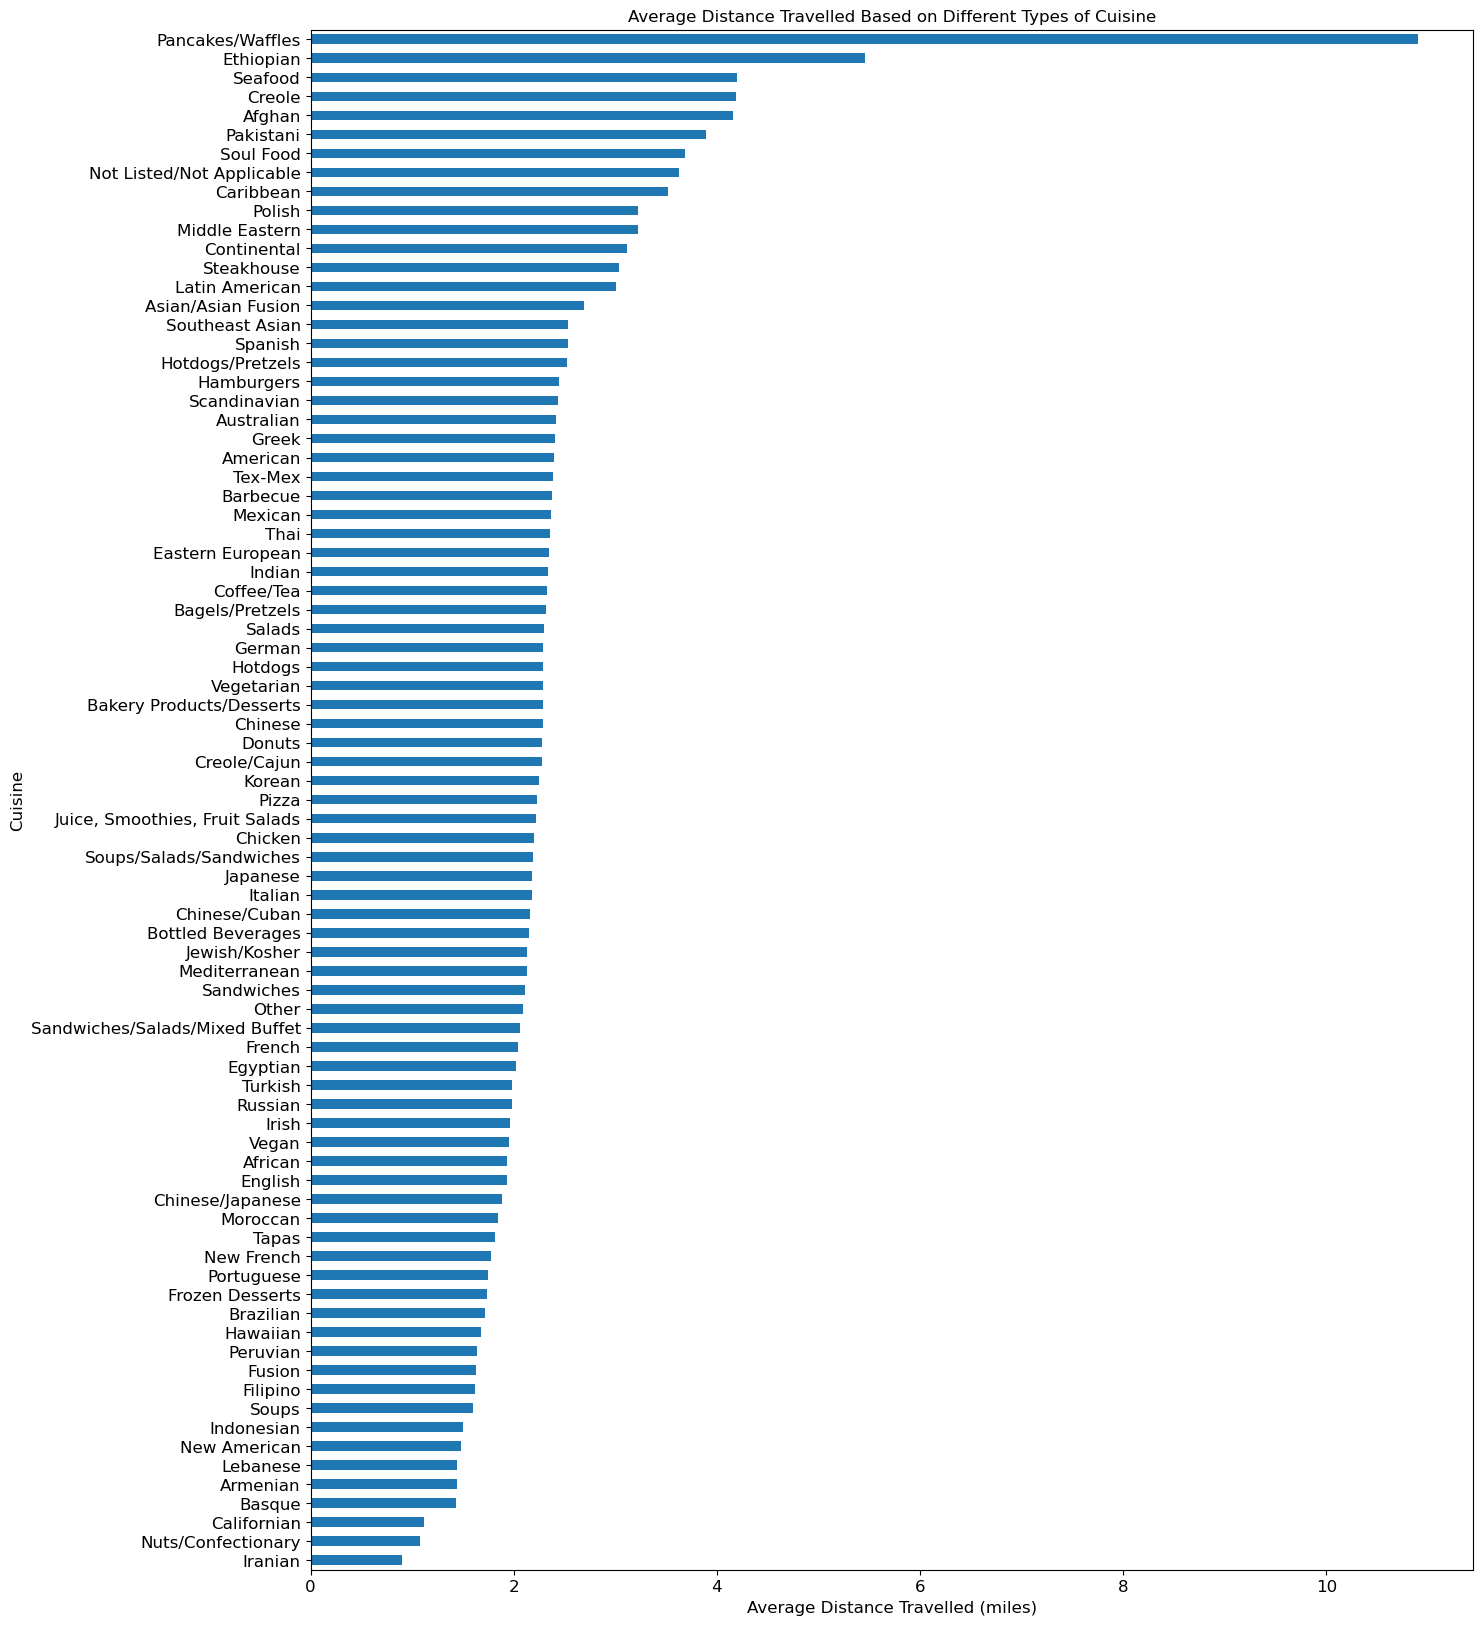

In [44]:
group_cuisine_distance = taxi_data.groupby('cuisine')['trip_distance'].mean().sort_values()
# del group_cuisine_distance['Mexican']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,20))
group_cuisine_distance.plot(kind='barh', fontsize=12)
plt.xlabel('Average Distance Travelled (miles)', fontsize=12)
plt.ylabel('Cuisine', fontsize=12)
plt.title('Average Distance Travelled Based on Different Types of Cuisine', fontsize=12)
plt.show()

We can see that people travel the most distance for cuisines that are popular but does not have it available at nearby location like **Pancakes/Waffles, Ethiopian, Afgan**.

### How far do people travel based on the borough where the restaurant is located?

In [45]:
pd.unique(taxi_data['borough'])

array(['Manhattan', 'Queens', 'Brooklyn', 'Bronx'], dtype=object)

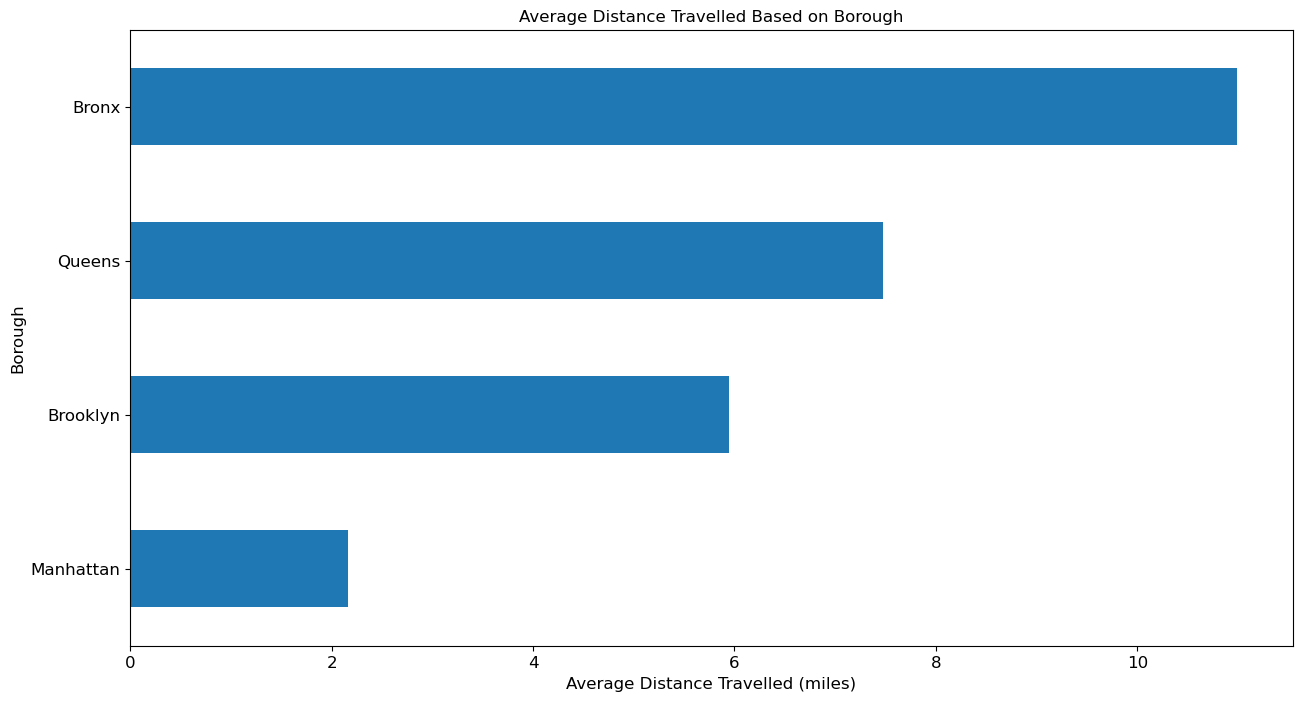

In [46]:
group_borough_distance = taxi_data.groupby('borough')['trip_distance'].mean().sort_values()
# del group_cuisine_distance['Mexican']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_borough_distance.plot(kind='barh', fontsize=12)
plt.xlabel('Average Distance Travelled (miles)', fontsize=12)
plt.ylabel('Borough', fontsize=12)
plt.title('Average Distance Travelled Based on Borough', fontsize=12)
plt.show()

We can see that people from **BRONX** travel the most for different restaurants because most of poupular restaurants are far from BRONX and people from **MANHATTAN** travel the least beacuse people easily find a good restaurant in MANHATTAN.

NOTE: We could not find any restuarants with 50 meters of the drop location for the taxi ride in our dataset based on the filters we used.

### How far do people travel at different meal time?

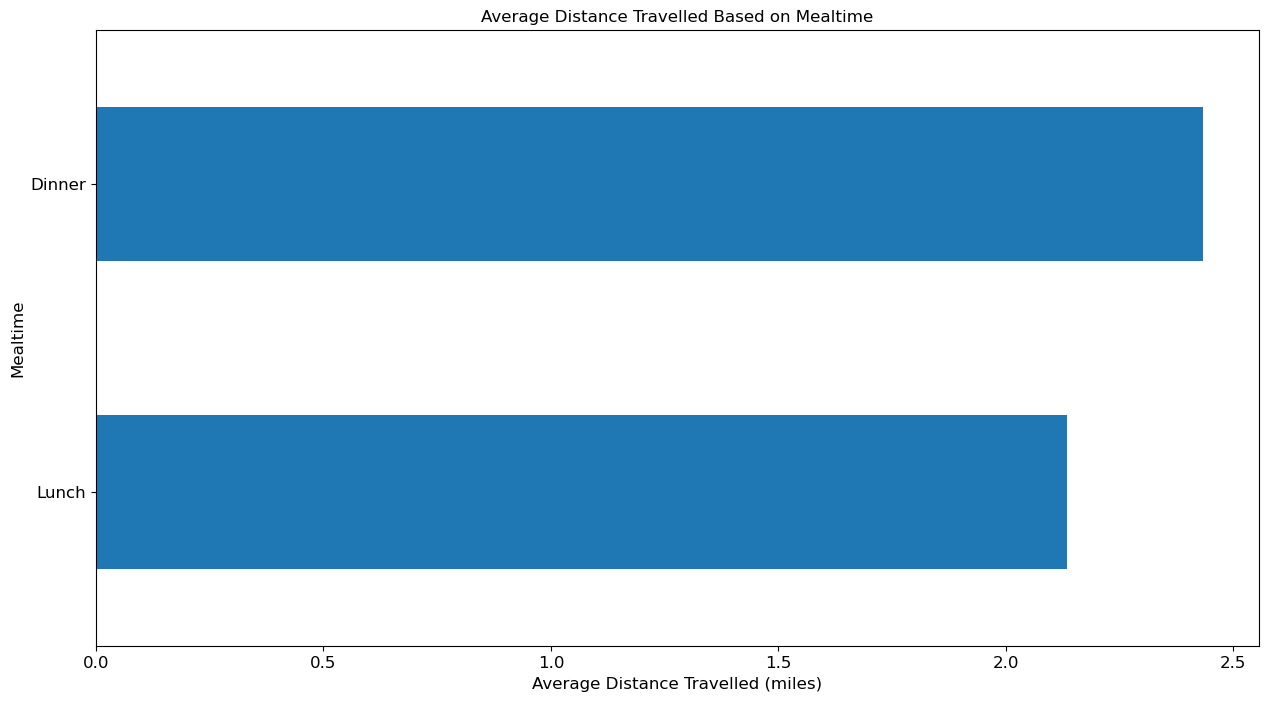

In [47]:
group_mealtime_distance = taxi_data.groupby(['mealtime'])['trip_distance'].mean().sort_values()

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_mealtime_distance.plot(kind='barh', fontsize=12)
plt.xlabel('Average Distance Travelled (miles)', fontsize=12)
plt.ylabel('Mealtime', fontsize=12)
plt.title('Average Distance Travelled Based on Mealtime', fontsize=12)
plt.show()

We can see that people travel more for **Dinner** than they travel for **Lunch**.

### What is the average tipping rate for different types of cuisine?

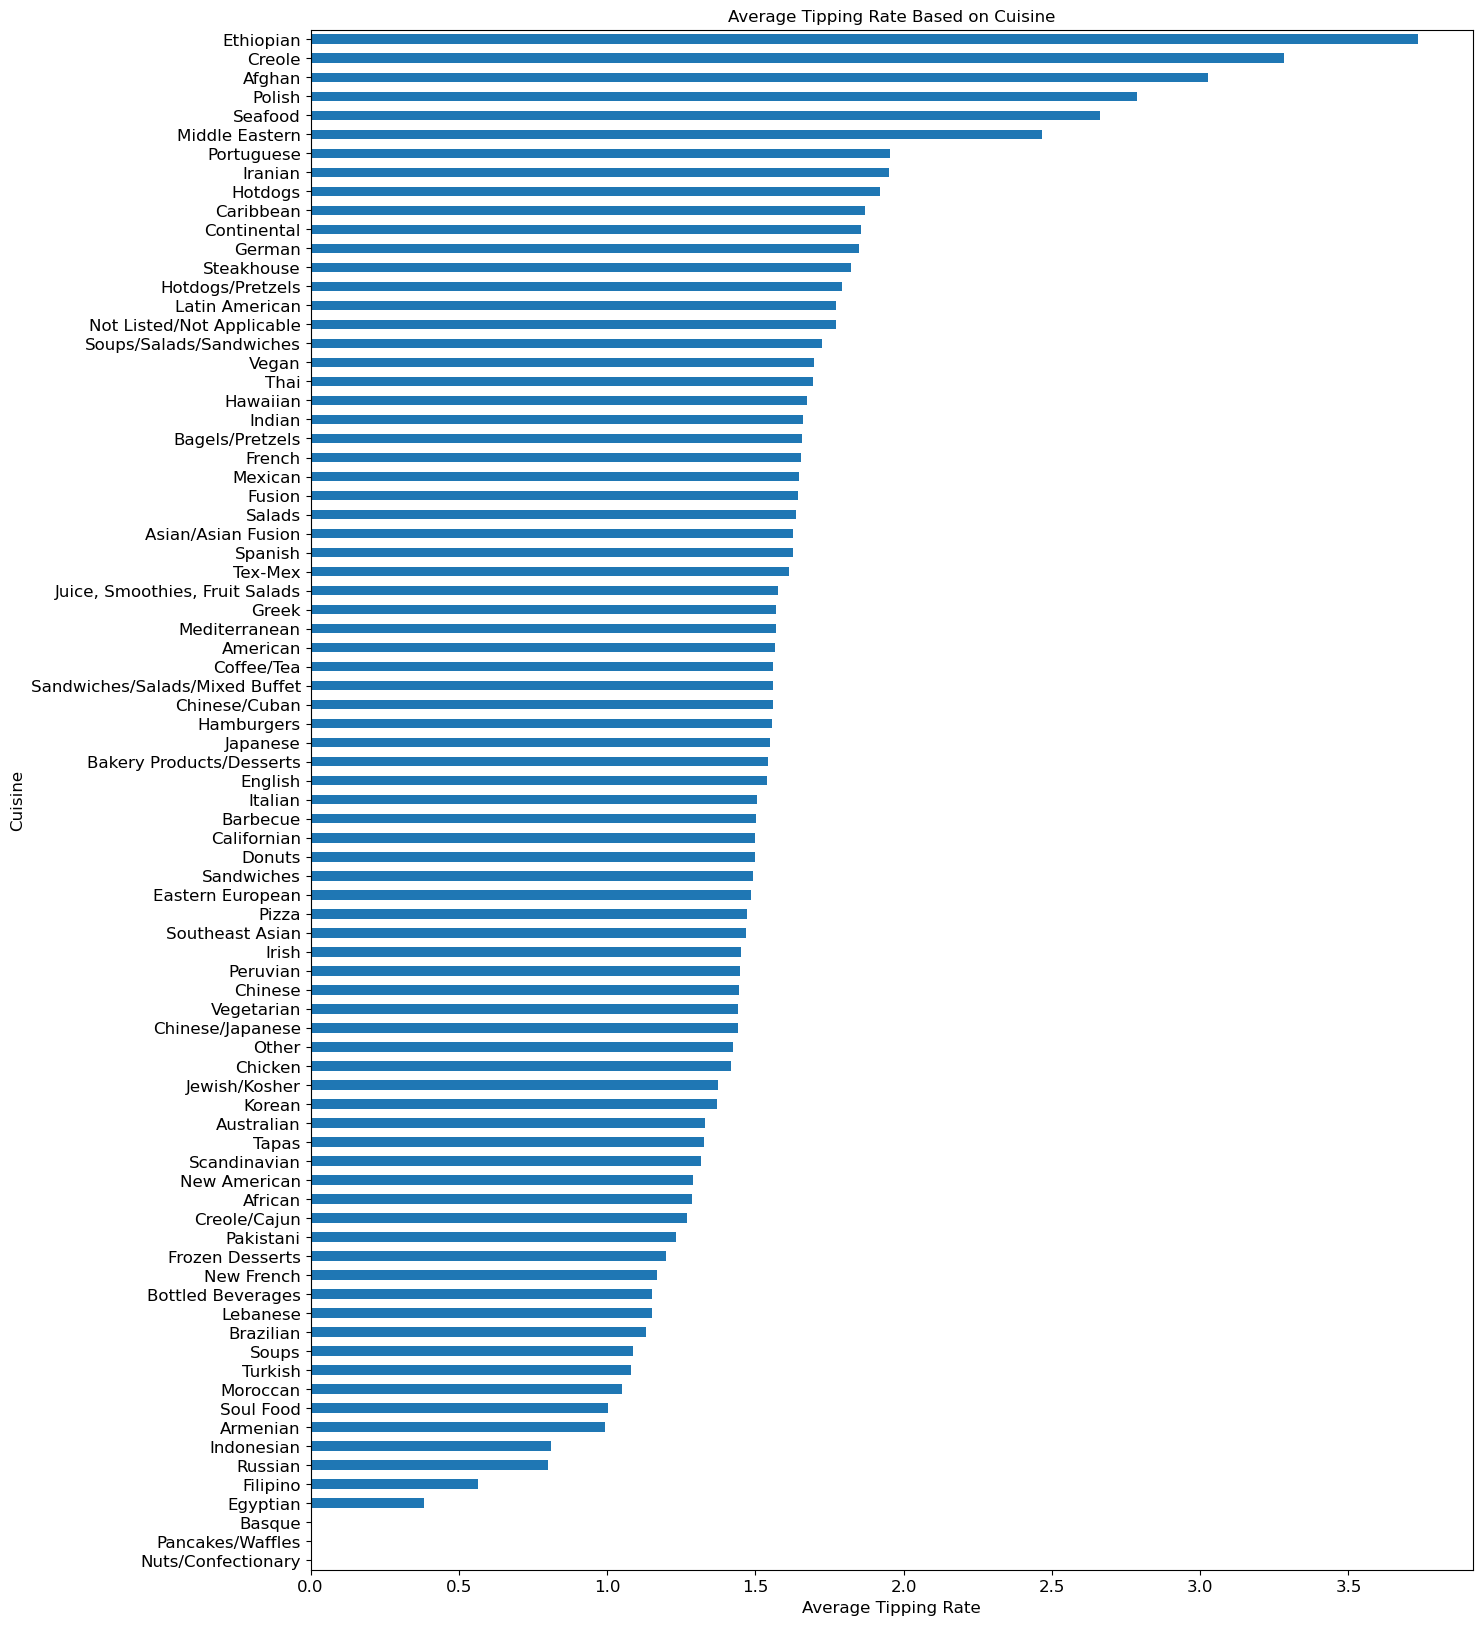

In [48]:
group_borough_tip = taxi_data.groupby('cuisine')['tip_amount'].mean().sort_values()

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,20))
group_borough_tip.plot(kind='barh', fontsize=12)
plt.xlabel('Average Tipping Rate', fontsize=12)
plt.ylabel('Cuisine', fontsize=12)
plt.title('Average Tipping Rate Based on Cuisine', fontsize=12)
plt.show()

We can see that the tipping rate is almost proportional to the average distance travel. But, for some of the most popular cuisines, the tipping rate is zero.

In [49]:
taxi_data.loc[taxi_data['cuisine']=="Pancakes/Waffles"]

tpep_dropoff_datetime  passenger_count  trip_distance  \
75165  2015-01-15 17:07:08 +00:00                1           10.9   

       dropoff_longitude  dropoff_latitude  tip_amount mealtime  \
75165         -73.938164         40.847263         0.0   Dinner   

       possible_restaurant           cuisine    borough  res_latitude  \
75165             155688.0  Pancakes/Waffles  Manhattan     40.847226   

       res_longitude  
75165     -73.938124

### What is the average tipping rate for different borough?

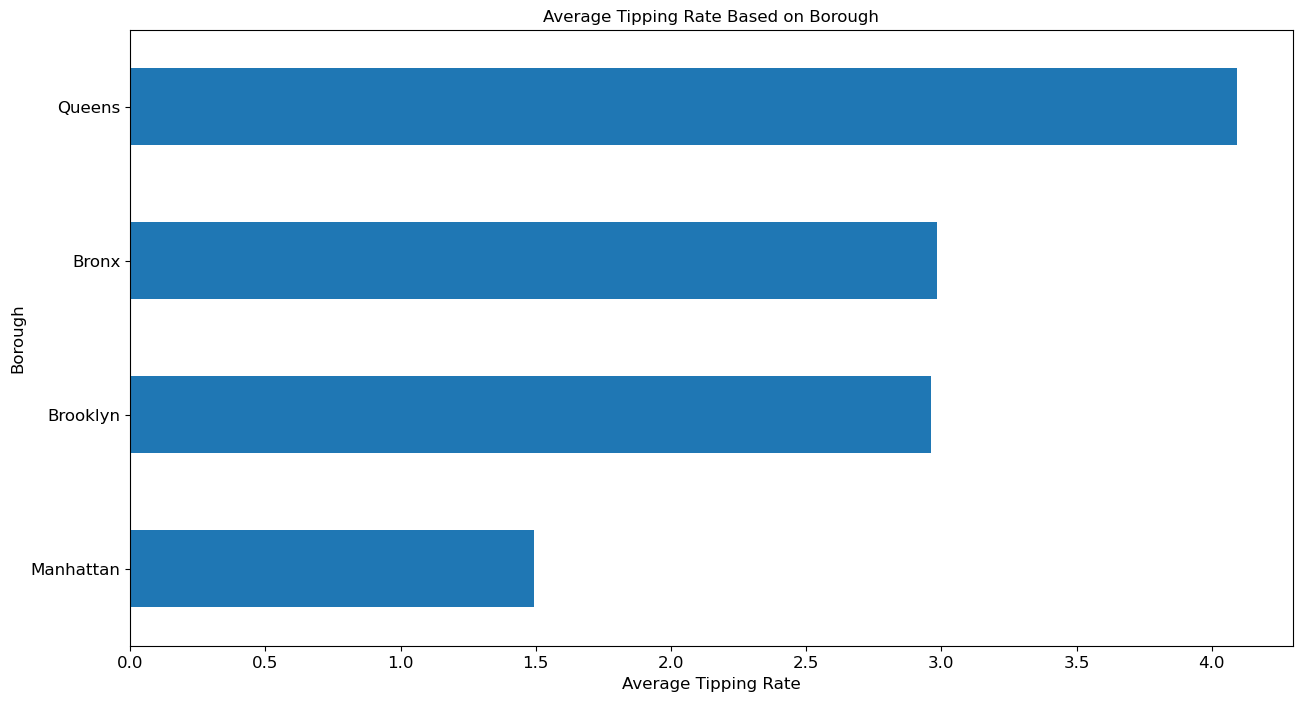

In [50]:
group_borough_tip = taxi_data.groupby('borough')['tip_amount'].mean().sort_values()

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_borough_tip.plot(kind='barh', fontsize=12)
plt.xlabel('Average Tipping Rate', fontsize=12)
plt.ylabel('Borough', fontsize=12)
plt.title('Average Tipping Rate Based on Borough', fontsize=12)
plt.show()

We can see that people from **Queens** prefer to tip more amount. But people from **Manhattan** travel the least distance for meals so the average tipping rate is lowest.

NOTE: We could not find any restuarants with 50 meters of the drop location for the taxi ride in our dataset based on the filters we used.

### What is the average tipping rate for different mealtime?

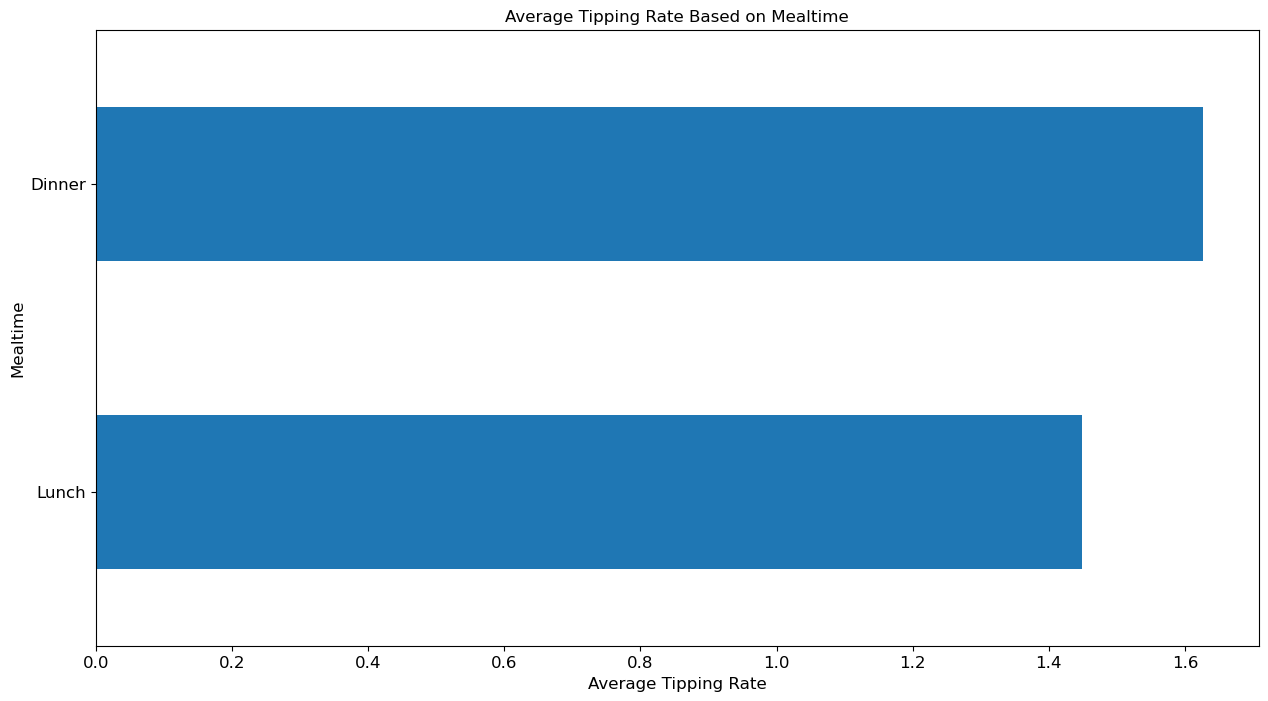

In [51]:
group_mealtime_tip = taxi_data.groupby(['mealtime'])['tip_amount'].mean().sort_values()

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_mealtime_tip.plot(kind='barh', fontsize=12)
plt.xlabel('Average Tipping Rate', fontsize=12)
plt.ylabel('Mealtime', fontsize=12)
plt.title('Average Tipping Rate Based on Mealtime', fontsize=12)
plt.show()

Average tipping rate for different mealtime is also proportional to the distance travelled by the passengers.

### What is the average tipping rate for different number of passengers?

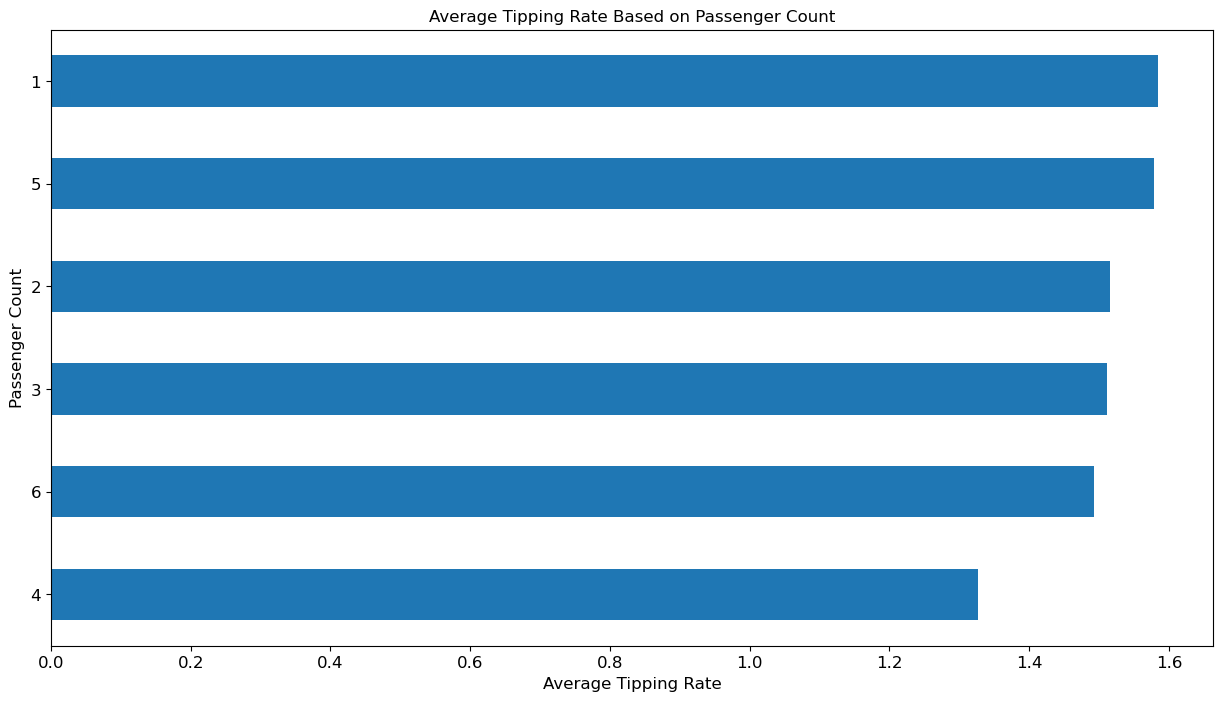

In [52]:
group_passengers_tip = taxi_data.groupby(['passenger_count'])['tip_amount'].mean().sort_values()
# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_passengers_tip.plot(kind='barh', fontsize=12)
plt.xlabel('Average Tipping Rate', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.title('Average Tipping Rate Based on Passenger Count', fontsize=12)
plt.show()

We can see that there is not much variation in the tipping amount based on passenger count.

## Predictive Model
**Describe how you would set up a predictive model** of restaurant cuisine type to be visited by a taxi rider based on information present in the two datasets. Feel free to suggest other data sources you would bring in to support your predictive model. Please note you do NOT have to implement this model.

To set up a predictive model of restaurant cuisine type to be visited by a taxi rider based on the given datasets, we can follow these steps:

### 1. Data Preparation:
We would first need to preprocess and clean the datasets. This would involve removing any duplicate or missing data, standardizing data formats, and merging the two datasets based on the location information. We may also need to convert location data into numerical features that would be useful for model convergence.

### 2. Data Preparation:
We can create new features based on the existing datasets to improve the model accuracy. 
For example, we can calculate the distance between the taxi drop location and each restaurant to create a proximity feature. 

### 3. Model Selection:
Since our goal is to map the resturant's location with its cuisine type and taxi drop location to find which cuisine type has been visited, our primary features would be geographic location.
We can use supervised machine learning algorithms such as decision trees, random forests, or logistic regression to train our predictive model.

Some of the better models would be:

**Spatial Regression:**
This model can incorporates spatial autocorrelation into the analysis that means we can use fact that nearby observations are more likely to be similar than distant observations. Using this correlation spatial regression models 
can improve the accuracy of predictions based on geographic data given in our datasets.

**Geographically Weighted Regression:**
Geographically Weighted Regression (GWR) is a type of spatial regression that allows for spatially varying coefficients. In other words, it recognizes that the relationship between the input variables and the output variable may differ across space. GWR can be useful when there are spatially varying relationships between variables that cannot be captured by a global model.

**Random Forests with Geospatial Data:**
Random forests can be used with geographic data by incorporating geographic variables as input features. For example, we can include variables such as latitude, longitude, elevation, or distance to nearby landmarks as input features. Random forests are particularly useful when there are non-linear relationships between input variables and the output variable.

Input: Traxi drop location, proximity, and other relevant features.

Target Output: Cusine Type 

### 4. Model Evaluation:
We would need to evaluate the performance of our model using metrics such as accuracy, precision, and recall. We can also use techniques such as cross-validation to ensure that our model generalizes well to new data.

We can also plot the optimization history and tweak the hyperparameters to further increase the accuracy.

### 5. Model Evaluation:
We can add more context to the data that would further improve the accruacy of the models. For example, adding holidays and festivals would tell us what kind cusine people prefer to have during the festivals. 